In [1]:
%matplotlib inline
import argparse
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# set a manual seed to prevent different result while every running

manualSeed = 999
print("Random seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random seed: 999


In [4]:
data_root = "/content/gdrive/MyDrive/GIDS-GAN_based_Intrusion_Detection_System_for_In-Vehicle_Network/CAN_image_dataset(L)/"    # dataset root
workers = 1                 # using thread numbers
batch_size = 128            # batch_size
nc = 1                      # number of channel from input images
num_epochs = 100             # number of training epochs
lr = 0.0001                 # learning rate
beta1 = 0.5                 # hyperparameter for adam optimizer
ngpu = 1                    # number of available gpu

In [5]:
dataset = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                                transforms.Resize((64,48)),
                               transforms.Grayscale(1),
                               transforms.ToTensor(),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=False,num_workers=workers,persistent_workers= True)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

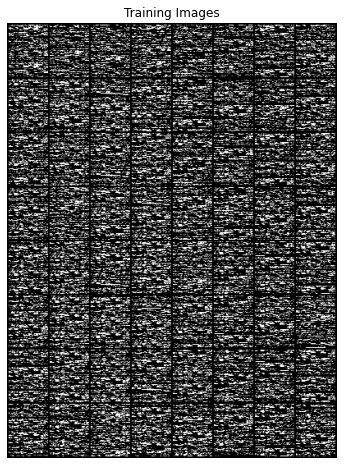

In [6]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))

In [7]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()

    def forward(self, x):
        # Do your print / debug stuff here
        print(x)
        return x

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# v1 : except nn.BatchNorm2d(channel size)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input : N x channel noise x 1 x 1
            nn.ConvTranspose2d(256,512,(4,3),stride=1,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # second layer
            nn.ConvTranspose2d(512,256,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # third layer
            nn.ConvTranspose2d(256,128,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # fourth layer,
            nn.ConvTranspose2d(128,64,4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Final layer
            nn.ConvTranspose2d(64,1,4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self,input):
        #x = self.main(input)
        #print("generated output shape: ",x.shape)
        return self.main(input)

In [10]:
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG,list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [11]:
class Discriminator(nn.Module):
    def __init__(self,ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu,
        self.main = nn.Sequential(
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(4,3),stride=(2,1),padding=1,bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(True),
            nn.Conv2d(1,1,(16,48),stride=1,padding=0,bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
       #x = self.main(input)
       # print("Discriminator output shape: ", x.shape)
        return self.main(input)

In [13]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD,list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(1, 1, kernel_size=(4, 3), stride=(2, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(1, 1, kernel_size=(16, 48), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)


In [12]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

NameError: ignored

In [ ]:
# train process0
from tqdm import tqdm
import time
from utils import save_model
# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #print("data: ", data[0].shape)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            save_model(model=netD,target_dir="saved_model/discriminator",model_name="discriminator_epoch.pth")
            save_model(model=netG,target_dir="saved_model/generator",model_name="generator_epoch.pth")
        iters += 1



Starting Training Loop...


  0%|          | 0/5 [00:00<?, ?it/s]

[0/5][0/44]	Loss_D: 3.0582	Loss_G: 0.1167	D(x): 0.4540	D(G(z)): 0.8934 / 0.8901
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 20%|██        | 1/5 [1:07:09<4:28:37, 4029.40s/it]

[1/5][0/44]	Loss_D: 4.3267	Loss_G: 0.0279	D(x): 0.5125	D(G(z)): 0.9735 / 0.9725


 40%|████      | 2/5 [1:07:18<1:23:13, 1664.35s/it]

[2/5][0/44]	Loss_D: 3.9960	Loss_G: 0.0357	D(x): 0.5591	D(G(z)): 0.9665 / 0.9649


 60%|██████    | 3/5 [1:07:26<30:16, 908.23s/it]   

[3/5][0/44]	Loss_D: 3.6443	Loss_G: 0.0498	D(x): 0.5730	D(G(z)): 0.9538 / 0.9515


 80%|████████  | 4/5 [1:07:35<09:13, 553.19s/it]

[4/5][0/44]	Loss_D: 3.4042	Loss_G: 0.0624	D(x): 0.5790	D(G(z)): 0.9422 / 0.9395


100%|██████████| 5/5 [1:07:44<00:00, 812.81s/it]

[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


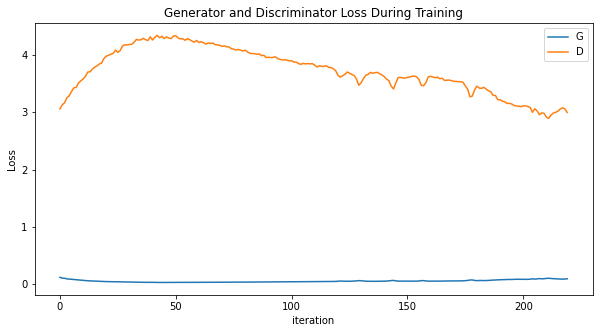

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Generator and Discriminator Loss During Training')
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

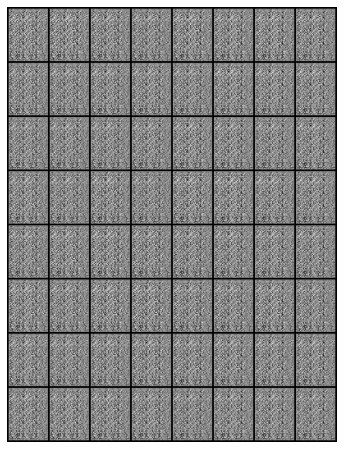

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis('off')
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated = True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000,blit=True)

HTML(ani.to_jshtml())

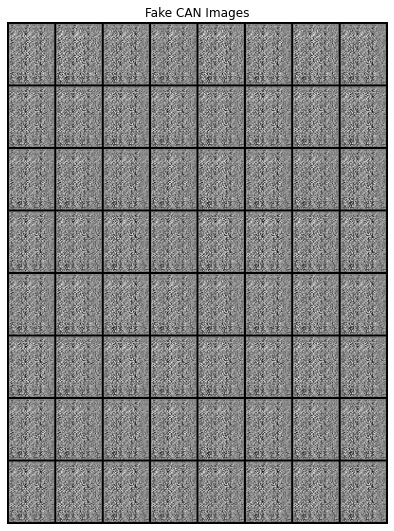

In [ ]:
# bring real datas form dataloader
real_batch = next(iter(dataloader))

# print real images on display
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Fake CAN Images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
netD.load_state_dict(torch.load(f="/content/saved_model/discriminator/discriminator_epoch.pth"))
netD.to(device)
netG.load_state_dict(torch.load(f="/content/saved_model/generator/generator_epoch.pth"))
netG.to(device)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(4, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
# train process0
from tqdm import tqdm
import time
from utils import save_model
# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #print("data: ", data[0].shape)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            save_model(model=netD,target_dir="saved_model/discriminator",model_name="discriminator_epoch.pth")
            save_model(model=netG,target_dir="saved_model/generator",model_name="generator_epoch.pth")
        iters += 1



Starting Training Loop...


  0%|          | 0/95 [00:00<?, ?it/s]

[0/95][0/44]	Loss_D: 2.9648	Loss_G: 0.0957	D(x): 0.5926	D(G(z)): 0.9124 / 0.9088
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


  1%|          | 1/95 [00:10<15:53, 10.15s/it]

[1/95][0/44]	Loss_D: 2.7251	Loss_G: 0.1259	D(x): 0.5788	D(G(z)): 0.8861 / 0.8818


  2%|▏         | 2/95 [00:18<14:13,  9.18s/it]

[2/95][0/44]	Loss_D: 2.5342	Loss_G: 0.1593	D(x): 0.5645	D(G(z)): 0.8590 / 0.8527


  3%|▎         | 3/95 [00:27<13:58,  9.11s/it]

[3/95][0/44]	Loss_D: 2.3577	Loss_G: 0.2030	D(x): 0.5432	D(G(z)): 0.8255 / 0.8163


  4%|▍         | 4/95 [00:36<13:45,  9.07s/it]

[4/95][0/44]	Loss_D: 2.0507	Loss_G: 0.2979	D(x): 0.5166	D(G(z)): 0.7507 / 0.7424


  5%|▌         | 5/95 [00:45<13:13,  8.81s/it]

[5/95][0/44]	Loss_D: 2.0896	Loss_G: 0.2842	D(x): 0.5176	D(G(z)): 0.7607 / 0.7526


  6%|▋         | 6/95 [00:54<13:14,  8.92s/it]

[6/95][0/44]	Loss_D: 1.9208	Loss_G: 0.3424	D(x): 0.5208	D(G(z)): 0.7185 / 0.7101


  7%|▋         | 7/95 [01:03<13:13,  9.02s/it]

[7/95][0/44]	Loss_D: 1.6878	Loss_G: 0.4355	D(x): 0.5398	D(G(z)): 0.6571 / 0.6470


  8%|▊         | 8/95 [01:11<12:48,  8.83s/it]

[8/95][0/44]	Loss_D: 1.7024	Loss_G: 0.4323	D(x): 0.5354	D(G(z)): 0.6593 / 0.6490


  9%|▉         | 9/95 [01:20<12:48,  8.93s/it]

[9/95][0/44]	Loss_D: 1.6767	Loss_G: 0.4526	D(x): 0.5305	D(G(z)): 0.6473 / 0.6360


 11%|█         | 10/95 [01:30<12:43,  8.98s/it]

[10/95][0/44]	Loss_D: 1.6665	Loss_G: 0.4512	D(x): 0.5338	D(G(z)): 0.6459 / 0.6369


 12%|█▏        | 11/95 [01:38<12:19,  8.80s/it]

[11/95][0/44]	Loss_D: 1.5743	Loss_G: 0.5019	D(x): 0.5435	D(G(z)): 0.6188 / 0.6054
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 13%|█▎        | 12/95 [01:47<12:21,  8.93s/it]

[12/95][0/44]	Loss_D: 1.4505	Loss_G: 0.6063	D(x): 0.5275	D(G(z)): 0.5554 / 0.5454


 14%|█▎        | 13/95 [01:57<12:23,  9.07s/it]

[13/95][0/44]	Loss_D: 1.4521	Loss_G: 0.6091	D(x): 0.5232	D(G(z)): 0.5524 / 0.5438


 15%|█▍        | 14/95 [02:05<12:00,  8.89s/it]

[14/95][0/44]	Loss_D: 1.4702	Loss_G: 0.6109	D(x): 0.5128	D(G(z)): 0.5516 / 0.5428


 16%|█▌        | 15/95 [02:14<11:56,  8.96s/it]

[15/95][0/44]	Loss_D: 1.4793	Loss_G: 0.5907	D(x): 0.5202	D(G(z)): 0.5620 / 0.5539


 17%|█▋        | 16/95 [02:23<11:51,  9.00s/it]

[16/95][0/44]	Loss_D: 1.3977	Loss_G: 0.6561	D(x): 0.5248	D(G(z)): 0.5289 / 0.5188


 18%|█▊        | 17/95 [02:32<11:28,  8.83s/it]

[17/95][0/44]	Loss_D: 1.4175	Loss_G: 0.6587	D(x): 0.5108	D(G(z)): 0.5255 / 0.5175


 19%|█▉        | 18/95 [02:41<11:25,  8.91s/it]

[18/95][0/44]	Loss_D: 1.4552	Loss_G: 0.6204	D(x): 0.5176	D(G(z)): 0.5491 / 0.5377


 20%|██        | 19/95 [02:50<11:18,  8.92s/it]

[19/95][0/44]	Loss_D: 1.3830	Loss_G: 0.6755	D(x): 0.5175	D(G(z)): 0.5152 / 0.5089


 21%|██        | 20/95 [02:58<10:59,  8.80s/it]

[20/95][0/44]	Loss_D: 1.4678	Loss_G: 0.6081	D(x): 0.5211	D(G(z)): 0.5577 / 0.5444


 22%|██▏       | 21/95 [03:07<10:57,  8.88s/it]

[21/95][0/44]	Loss_D: 1.4418	Loss_G: 0.5944	D(x): 0.5369	D(G(z)): 0.5594 / 0.5519


 23%|██▎       | 22/95 [03:16<10:47,  8.87s/it]

[22/95][0/44]	Loss_D: 1.3727	Loss_G: 0.6799	D(x): 0.5275	D(G(z)): 0.5195 / 0.5067
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 24%|██▍       | 23/95 [03:25<10:33,  8.80s/it]

[23/95][0/44]	Loss_D: 1.3734	Loss_G: 0.6726	D(x): 0.5304	D(G(z)): 0.5225 / 0.5104


 25%|██▌       | 24/95 [03:34<10:30,  8.88s/it]

[24/95][0/44]	Loss_D: 1.5422	Loss_G: 0.5390	D(x): 0.5329	D(G(z)): 0.5985 / 0.5833


 26%|██▋       | 25/95 [03:43<10:19,  8.85s/it]

[25/95][0/44]	Loss_D: 1.5046	Loss_G: 0.5679	D(x): 0.5277	D(G(z)): 0.5790 / 0.5667


 27%|██▋       | 26/95 [03:51<10:08,  8.82s/it]

[26/95][0/44]	Loss_D: 1.3838	Loss_G: 0.6640	D(x): 0.5260	D(G(z)): 0.5234 / 0.5148


 28%|██▊       | 27/95 [04:01<10:06,  8.92s/it]

[27/95][0/44]	Loss_D: 1.4274	Loss_G: 0.6002	D(x): 0.5430	D(G(z)): 0.5580 / 0.5487


 29%|██▉       | 28/95 [04:09<09:50,  8.81s/it]

[28/95][0/44]	Loss_D: 1.3998	Loss_G: 0.6171	D(x): 0.5510	D(G(z)): 0.5523 / 0.5395


 31%|███       | 29/95 [04:18<09:41,  8.81s/it]

[29/95][0/44]	Loss_D: 1.3291	Loss_G: 0.6992	D(x): 0.5348	D(G(z)): 0.5050 / 0.4970


 32%|███▏      | 30/95 [04:27<09:37,  8.88s/it]

[30/95][0/44]	Loss_D: 1.4117	Loss_G: 0.6341	D(x): 0.5280	D(G(z)): 0.5382 / 0.5304


 33%|███▎      | 31/95 [04:36<09:22,  8.79s/it]

[31/95][0/44]	Loss_D: 1.4075	Loss_G: 0.6384	D(x): 0.5289	D(G(z)): 0.5371 / 0.5281


 34%|███▎      | 32/95 [04:44<09:15,  8.82s/it]

[32/95][0/44]	Loss_D: 1.3477	Loss_G: 0.6681	D(x): 0.5462	D(G(z)): 0.5242 / 0.5127


 35%|███▍      | 33/95 [04:54<09:12,  8.92s/it]

[33/95][0/44]	Loss_D: 1.2509	Loss_G: 0.7493	D(x): 0.5538	D(G(z)): 0.4829 / 0.4727


 36%|███▌      | 34/95 [05:02<08:55,  8.78s/it]

[34/95][0/44]	Loss_D: 1.5015	Loss_G: 0.5550	D(x): 0.5369	D(G(z)): 0.5849 / 0.5741
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 37%|███▋      | 35/95 [05:11<08:53,  8.89s/it]

[35/95][0/44]	Loss_D: 1.3799	Loss_G: 0.6547	D(x): 0.5315	D(G(z)): 0.5264 / 0.5196


 38%|███▊      | 36/95 [05:20<08:48,  8.96s/it]

[36/95][0/44]	Loss_D: 1.4698	Loss_G: 0.6101	D(x): 0.5121	D(G(z)): 0.5508 / 0.5433


 39%|███▉      | 37/95 [05:29<08:26,  8.74s/it]

[37/95][0/44]	Loss_D: 1.3787	Loss_G: 0.6678	D(x): 0.5233	D(G(z)): 0.5185 / 0.5128


 40%|████      | 38/95 [05:37<08:21,  8.80s/it]

[38/95][0/44]	Loss_D: 1.2790	Loss_G: 0.7221	D(x): 0.5437	D(G(z)): 0.4880 / 0.4857


 41%|████      | 39/95 [05:47<08:18,  8.90s/it]

[39/95][0/44]	Loss_D: 1.2252	Loss_G: 0.7129	D(x): 0.5793	D(G(z)): 0.4929 / 0.4902


 42%|████▏     | 40/95 [05:55<08:00,  8.74s/it]

[40/95][0/44]	Loss_D: 1.2532	Loss_G: 0.6808	D(x): 0.5855	D(G(z)): 0.5121 / 0.5062


 43%|████▎     | 41/95 [06:04<07:57,  8.84s/it]

[41/95][0/44]	Loss_D: 1.3274	Loss_G: 0.6651	D(x): 0.5561	D(G(z)): 0.5230 / 0.5142


 44%|████▍     | 42/95 [06:13<07:50,  8.88s/it]

[42/95][0/44]	Loss_D: 1.6205	Loss_G: 0.5079	D(x): 0.5130	D(G(z)): 0.6142 / 0.6017


 45%|████▌     | 43/95 [06:21<07:34,  8.74s/it]

[43/95][0/44]	Loss_D: 1.3110	Loss_G: 0.7491	D(x): 0.5173	D(G(z)): 0.4786 / 0.4728


 46%|████▋     | 44/95 [06:31<07:31,  8.86s/it]

[44/95][0/44]	Loss_D: 1.4423	Loss_G: 0.6628	D(x): 0.4981	D(G(z)): 0.5251 / 0.5154


 47%|████▋     | 45/95 [06:39<07:22,  8.85s/it]

[45/95][0/44]	Loss_D: 1.4599	Loss_G: 0.6310	D(x): 0.5051	D(G(z)): 0.5399 / 0.5321
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 48%|████▊     | 46/95 [06:48<07:08,  8.74s/it]

[46/95][0/44]	Loss_D: 1.6895	Loss_G: 0.4590	D(x): 0.5181	D(G(z)): 0.6435 / 0.6319


 49%|████▉     | 47/95 [06:57<07:03,  8.83s/it]

[47/95][0/44]	Loss_D: 1.3190	Loss_G: 0.7212	D(x): 0.5248	D(G(z)): 0.4903 / 0.4862


 51%|█████     | 48/95 [07:06<06:59,  8.93s/it]

[48/95][0/44]	Loss_D: 1.3748	Loss_G: 0.6234	D(x): 0.5511	D(G(z)): 0.5410 / 0.5361


 52%|█████▏    | 49/95 [07:15<06:47,  8.85s/it]

[49/95][0/44]	Loss_D: 1.2126	Loss_G: 0.7369	D(x): 0.5743	D(G(z)): 0.4819 / 0.4786


 53%|█████▎    | 50/95 [07:24<06:41,  8.91s/it]

[50/95][0/44]	Loss_D: 1.1654	Loss_G: 0.7338	D(x): 0.6049	D(G(z)): 0.4844 / 0.4801


 54%|█████▎    | 51/95 [07:33<06:32,  8.92s/it]

[51/95][0/44]	Loss_D: 1.1796	Loss_G: 0.6795	D(x): 0.6287	D(G(z)): 0.5109 / 0.5069


 55%|█████▍    | 52/95 [07:41<06:19,  8.83s/it]

[52/95][0/44]	Loss_D: 1.1642	Loss_G: 0.6771	D(x): 0.6403	D(G(z)): 0.5122 / 0.5081


 56%|█████▌    | 53/95 [07:51<06:14,  8.93s/it]

[53/95][0/44]	Loss_D: 1.1946	Loss_G: 0.7194	D(x): 0.5975	D(G(z)): 0.4927 / 0.4871


 57%|█████▋    | 54/95 [07:59<06:02,  8.84s/it]

[54/95][0/44]	Loss_D: 1.1471	Loss_G: 0.7302	D(x): 0.6207	D(G(z)): 0.4879 / 0.4818


 58%|█████▊    | 55/95 [08:08<05:51,  8.78s/it]

[55/95][0/44]	Loss_D: 1.1391	Loss_G: 0.6910	D(x): 0.6475	D(G(z)): 0.5052 / 0.5011


 59%|█████▉    | 56/95 [08:17<05:45,  8.86s/it]

[56/95][0/44]	Loss_D: 1.0497	Loss_G: 0.7733	D(x): 0.6604	D(G(z)): 0.4695 / 0.4615
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 60%|██████    | 57/95 [08:25<05:32,  8.74s/it]

[57/95][0/44]	Loss_D: 1.0223	Loss_G: 0.8163	D(x): 0.6563	D(G(z)): 0.4512 / 0.4421


 61%|██████    | 58/95 [08:34<05:24,  8.76s/it]

[58/95][0/44]	Loss_D: 1.2158	Loss_G: 0.6808	D(x): 0.6191	D(G(z)): 0.5202 / 0.5062


 62%|██████▏   | 59/95 [08:43<05:18,  8.85s/it]

[59/95][0/44]	Loss_D: 1.0232	Loss_G: 0.8307	D(x): 0.6469	D(G(z)): 0.4429 / 0.4358


 63%|██████▎   | 60/95 [08:52<05:05,  8.73s/it]

[60/95][0/44]	Loss_D: 1.0843	Loss_G: 0.8479	D(x): 0.6096	D(G(z)): 0.4420 / 0.4283


 64%|██████▍   | 61/95 [09:01<04:58,  8.79s/it]

[61/95][0/44]	Loss_D: 1.4621	Loss_G: 0.6537	D(x): 0.5204	D(G(z)): 0.5513 / 0.5201


 65%|██████▌   | 62/95 [09:10<04:51,  8.84s/it]

[62/95][0/44]	Loss_D: 1.1875	Loss_G: 0.6479	D(x): 0.6556	D(G(z)): 0.5331 / 0.5232


 66%|██████▋   | 63/95 [09:18<04:37,  8.68s/it]

[63/95][0/44]	Loss_D: 1.6110	Loss_G: 0.5399	D(x): 0.5134	D(G(z)): 0.6078 / 0.5828


 67%|██████▋   | 64/95 [09:27<04:32,  8.79s/it]

[64/95][0/44]	Loss_D: 1.4556	Loss_G: 0.5862	D(x): 0.5600	D(G(z)): 0.5808 / 0.5565


 68%|██████▊   | 65/95 [09:36<04:24,  8.82s/it]

[65/95][0/44]	Loss_D: 1.0844	Loss_G: 0.8106	D(x): 0.6153	D(G(z)): 0.4480 / 0.4446


 69%|██████▉   | 66/95 [09:44<04:12,  8.69s/it]

[66/95][0/44]	Loss_D: 1.4160	Loss_G: 0.5879	D(x): 0.5863	D(G(z)): 0.5840 / 0.5555


 71%|███████   | 67/95 [09:53<04:05,  8.78s/it]

[67/95][0/44]	Loss_D: 1.6204	Loss_G: 0.5340	D(x): 0.5111	D(G(z)): 0.6108 / 0.5862


 72%|███████▏  | 68/95 [10:02<03:59,  8.86s/it]

[68/95][0/44]	Loss_D: 1.9386	Loss_G: 0.4263	D(x): 0.4456	D(G(z)): 0.6750 / 0.6529
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 73%|███████▎  | 69/95 [10:11<03:46,  8.70s/it]

[69/95][0/44]	Loss_D: 2.2373	Loss_G: 0.3750	D(x): 0.3681	D(G(z)): 0.7088 / 0.6873


 74%|███████▎  | 70/95 [10:20<03:40,  8.84s/it]

[70/95][0/44]	Loss_D: 1.5068	Loss_G: 0.7967	D(x): 0.4084	D(G(z)): 0.4562 / 0.4508


 75%|███████▍  | 71/95 [10:29<03:32,  8.84s/it]

[71/95][0/44]	Loss_D: 1.9140	Loss_G: 0.4779	D(x): 0.4053	D(G(z)): 0.6353 / 0.6201


 76%|███████▌  | 72/95 [10:37<03:20,  8.72s/it]

[72/95][0/44]	Loss_D: 1.5126	Loss_G: 0.8031	D(x): 0.4029	D(G(z)): 0.4522 / 0.4479


 77%|███████▋  | 73/95 [10:46<03:13,  8.81s/it]

[73/95][0/44]	Loss_D: 1.4691	Loss_G: 0.7092	D(x): 0.4566	D(G(z)): 0.4953 / 0.4920


 78%|███████▊  | 74/95 [10:55<03:04,  8.79s/it]

[74/95][0/44]	Loss_D: 1.5690	Loss_G: 0.6442	D(x): 0.4493	D(G(z)): 0.5360 / 0.5251


 79%|███████▉  | 75/95 [11:03<02:55,  8.75s/it]

[75/95][0/44]	Loss_D: 1.4826	Loss_G: 0.6987	D(x): 0.4562	D(G(z)): 0.5019 / 0.4973


 80%|████████  | 76/95 [11:12<02:47,  8.80s/it]

[76/95][0/44]	Loss_D: 1.3956	Loss_G: 0.7360	D(x): 0.4796	D(G(z)): 0.4832 / 0.4790


 81%|████████  | 77/95 [11:21<02:36,  8.72s/it]

[77/95][0/44]	Loss_D: 1.3853	Loss_G: 0.7540	D(x): 0.4787	D(G(z)): 0.4769 / 0.4705


 82%|████████▏ | 78/95 [11:30<02:28,  8.74s/it]

[78/95][0/44]	Loss_D: 1.3337	Loss_G: 0.7916	D(x): 0.4858	D(G(z)): 0.4572 / 0.4531


 83%|████████▎ | 79/95 [11:39<02:21,  8.83s/it]

[79/95][0/44]	Loss_D: 1.2674	Loss_G: 0.7245	D(x): 0.5485	D(G(z)): 0.4864 / 0.4846
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 84%|████████▍ | 80/95 [11:47<02:10,  8.70s/it]

[80/95][0/44]	Loss_D: 1.2324	Loss_G: 0.7483	D(x): 0.5603	D(G(z)): 0.4792 / 0.4732


 85%|████████▌ | 81/95 [11:56<02:02,  8.78s/it]

[81/95][0/44]	Loss_D: 1.2263	Loss_G: 0.6915	D(x): 0.5928	D(G(z)): 0.5047 / 0.5008


 86%|████████▋ | 82/95 [12:05<01:54,  8.83s/it]

[82/95][0/44]	Loss_D: 1.1212	Loss_G: 0.7677	D(x): 0.6129	D(G(z)): 0.4677 / 0.4641


 87%|████████▋ | 83/95 [12:14<01:45,  8.76s/it]

[83/95][0/44]	Loss_D: 1.2232	Loss_G: 0.6470	D(x): 0.6337	D(G(z)): 0.5350 / 0.5236


 88%|████████▊ | 84/95 [12:23<01:38,  8.92s/it]

[84/95][0/44]	Loss_D: 1.3522	Loss_G: 0.5751	D(x): 0.6054	D(G(z)): 0.5721 / 0.5627


 89%|████████▉ | 85/95 [12:32<01:29,  8.94s/it]

[85/95][0/44]	Loss_D: 1.1631	Loss_G: 0.7812	D(x): 0.5828	D(G(z)): 0.4629 / 0.4579


 91%|█████████ | 86/95 [12:40<01:18,  8.75s/it]

[86/95][0/44]	Loss_D: 1.0832	Loss_G: 0.7938	D(x): 0.6238	D(G(z)): 0.4566 / 0.4521


 92%|█████████▏| 87/95 [12:49<01:10,  8.80s/it]

[87/95][0/44]	Loss_D: 1.1364	Loss_G: 0.6826	D(x): 0.6572	D(G(z)): 0.5109 / 0.5053


 93%|█████████▎| 88/95 [12:58<01:02,  8.89s/it]

[88/95][0/44]	Loss_D: 1.0340	Loss_G: 0.7589	D(x): 0.6742	D(G(z)): 0.4718 / 0.4682


 94%|█████████▎| 89/95 [13:07<00:52,  8.72s/it]

[89/95][0/44]	Loss_D: 1.2928	Loss_G: 0.6597	D(x): 0.5907	D(G(z)): 0.5340 / 0.5170


 95%|█████████▍| 90/95 [13:16<00:44,  8.82s/it]

[90/95][0/44]	Loss_D: 1.4390	Loss_G: 0.6493	D(x): 0.5115	D(G(z)): 0.5343 / 0.5224
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


 96%|█████████▌| 91/95 [13:25<00:35,  8.89s/it]

[91/95][0/44]	Loss_D: 1.4027	Loss_G: 0.6367	D(x): 0.5368	D(G(z)): 0.5402 / 0.5290


 97%|█████████▋| 92/95 [13:33<00:26,  8.72s/it]

[92/95][0/44]	Loss_D: 1.3564	Loss_G: 0.8191	D(x): 0.4707	D(G(z)): 0.4503 / 0.4409


 98%|█████████▊| 93/95 [13:42<00:17,  8.82s/it]

[93/95][0/44]	Loss_D: 1.5393	Loss_G: 0.7173	D(x): 0.4304	D(G(z)): 0.4989 / 0.4881


 99%|█████████▉| 94/95 [13:51<00:08,  8.80s/it]

[94/95][0/44]	Loss_D: 1.6434	Loss_G: 0.7105	D(x): 0.3928	D(G(z)): 0.5047 / 0.4914


100%|██████████| 95/95 [13:59<00:00,  8.84s/it]

[INFO] Saving model to: saved_model/discriminator/discriminator_epoch.pth
[INFO] Saving model to: saved_model/generator/generator_epoch.pth


In [14]:
netD.load_state_dict(torch.load(f="/content/saved_model/discriminator/discriminator_epoch_34.pth"))
netD.to(device)
netG.load_state_dict(torch.load(f="/content/saved_model/generator/generator_epoch_34.pth"))
netG.to(device)

FileNotFoundError: ignored

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64,256,1,1,device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lr, betas = (beta1, 0.999))

In [ ]:
 #train process0
from tqdm import tqdm
import time
from utils import save_model
# save losses to check training state
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# iterate epoch
for epoch in tqdm(range(num_epochs)):
    # iterate batch in an epoch
    for i ,data in enumerate(dataloader,0):
        ####################
        # (1) update discriminator network : maximize log(D(x)) + log(1 - D(G(z))))
        ####################
        # @@train real data@@
        netD.zero_grad()
        # Adapt to the size of the batches or the device to be used
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #print("data: ", data[0].shape)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device= device)
        # pass batch composed real data to D
        output = netD(real_cpu).view(-1)
        # get losses
        errD_real = criterion(output,label)
        # calculate degree of change while doing backpropagation
        errD_real.backward()
        D_x = output.mean().item()

        # @@ train fake data @@
        # Generate latent space vector used in Generator
        noise = torch.randn(b_size,256,1,1,device=device)
        
        # Generate fake image using G
        fake = netG(noise)
        label.fill_(fake_label)
        # Discriminate truth of data using D
        output = netD(fake.detach()).view(-1)
        # Calculate losses of D
        errD_fake = criterion(output,label)
        # Calculate changes through backpropagation and accumulate changes which get before
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # add losses which get from both fake image and real image
        # At this time, errD is not used in backpropagation, but is used when reporting the learning state afterwards.
        errD = errD_fake +errD_real

        # Update D
        optimizerD.step()

        ###################
        # (2) Update G network : maximize log(D(G(z)))
        ###################
        netG.zero_grad()
        label.fill_(real_label) # we use real label to get losses of Generator
        # Pass fake data to D again because we update D just now
        # At this time, G didn't update, but we get different value because D update
        output = netD(fake).view(-1)
        # get losses of G
        errG = criterion(output,label)
        # Calculate changes of G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        

        # print training state
        if i % 50 == 0:
             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # save losses to draw graph later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # save return value of G passed fixed noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            save_model(model=netD,target_dir="saved_model/discriminator",model_name=f"discriminator_epoch_{epoch}.pth")
            save_model(model=netG,target_dir="saved_model/generator",model_name=f"generator_epoch_{epoch}.pth")
        iters += 1



Starting Training Loop...


  0%|          | 0/100 [00:00<?, ?it/s]

[0/100][0/44]	Loss_D: 1.5948	Loss_G: 0.8705	D(x): 0.3535	D(G(z)): 0.4223 / 0.4187
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch_0.pth
[INFO] Saving model to: saved_model/generator/generator_epoch_0.pth


  1%|          | 1/100 [00:09<15:37,  9.47s/it]

[1/100][0/44]	Loss_D: 1.5165	Loss_G: 0.6624	D(x): 0.4634	D(G(z)): 0.5246 / 0.5156


  2%|▏         | 2/100 [00:18<15:00,  9.19s/it]

[2/100][0/44]	Loss_D: 1.6042	Loss_G: 0.6093	D(x): 0.4540	D(G(z)): 0.5557 / 0.5437


  3%|▎         | 3/100 [00:27<14:43,  9.11s/it]

[3/100][0/44]	Loss_D: 1.3664	Loss_G: 0.7352	D(x): 0.4943	D(G(z)): 0.4831 / 0.4794


  4%|▍         | 4/100 [00:35<14:09,  8.85s/it]

[4/100][0/44]	Loss_D: 1.5284	Loss_G: 0.6434	D(x): 0.4690	D(G(z)): 0.5367 / 0.5255


  5%|▌         | 5/100 [00:45<14:12,  8.97s/it]

[5/100][0/44]	Loss_D: 1.4592	Loss_G: 0.8261	D(x): 0.4218	D(G(z)): 0.4479 / 0.4378


  6%|▌         | 6/100 [00:54<14:07,  9.02s/it]

[6/100][0/44]	Loss_D: 1.5728	Loss_G: 0.8590	D(x): 0.3671	D(G(z)): 0.4339 / 0.4236


  7%|▋         | 7/100 [01:02<13:39,  8.81s/it]

[7/100][0/44]	Loss_D: 1.3684	Loss_G: 0.9100	D(x): 0.4292	D(G(z)): 0.4065 / 0.4025


  8%|▊         | 8/100 [01:11<13:43,  8.95s/it]

[8/100][0/44]	Loss_D: 1.5033	Loss_G: 0.6871	D(x): 0.4602	D(G(z)): 0.5164 / 0.5030


  9%|▉         | 9/100 [01:20<13:35,  8.96s/it]

[9/100][0/44]	Loss_D: 1.7041	Loss_G: 0.5888	D(x): 0.4230	D(G(z)): 0.5697 / 0.5550


 10%|█         | 10/100 [01:29<13:10,  8.78s/it]

[10/100][0/44]	Loss_D: 1.4836	Loss_G: 0.6992	D(x): 0.4591	D(G(z)): 0.5058 / 0.4970


 11%|█         | 11/100 [01:38<13:14,  8.92s/it]

[11/100][0/44]	Loss_D: 1.4659	Loss_G: 0.7363	D(x): 0.4514	D(G(z)): 0.4884 / 0.4789
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch_11.pth
[INFO] Saving model to: saved_model/generator/generator_epoch_11.pth


 12%|█▏        | 12/100 [01:47<13:10,  8.99s/it]

[12/100][0/44]	Loss_D: 1.4925	Loss_G: 0.6251	D(x): 0.4911	D(G(z)): 0.5421 / 0.5352


 13%|█▎        | 13/100 [01:55<12:44,  8.79s/it]

[13/100][0/44]	Loss_D: 1.4360	Loss_G: 0.6540	D(x): 0.5034	D(G(z)): 0.5274 / 0.5200


 14%|█▍        | 14/100 [02:04<12:42,  8.86s/it]

[14/100][0/44]	Loss_D: 1.3551	Loss_G: 0.6805	D(x): 0.5276	D(G(z)): 0.5110 / 0.5063


 15%|█▌        | 15/100 [02:13<12:33,  8.87s/it]

[15/100][0/44]	Loss_D: 1.2976	Loss_G: 0.7341	D(x): 0.5318	D(G(z)): 0.4862 / 0.4799


 16%|█▌        | 16/100 [02:22<12:17,  8.78s/it]

[16/100][0/44]	Loss_D: 1.4010	Loss_G: 0.6542	D(x): 0.5218	D(G(z)): 0.5277 / 0.5198


 17%|█▋        | 17/100 [02:31<12:14,  8.84s/it]

[17/100][0/44]	Loss_D: 1.3974	Loss_G: 0.6932	D(x): 0.5080	D(G(z)): 0.5131 / 0.5000


 18%|█▊        | 18/100 [02:40<12:06,  8.86s/it]

[18/100][0/44]	Loss_D: 1.4108	Loss_G: 0.6931	D(x): 0.4957	D(G(z)): 0.5077 / 0.5000


 19%|█▉        | 19/100 [02:49<11:54,  8.82s/it]

[19/100][0/44]	Loss_D: 1.4187	Loss_G: 0.7934	D(x): 0.4474	D(G(z)): 0.4588 / 0.4523


 20%|██        | 20/100 [02:58<11:50,  8.88s/it]

[20/100][0/44]	Loss_D: 1.3952	Loss_G: 0.7964	D(x): 0.4554	D(G(z)): 0.4558 / 0.4510


 21%|██        | 21/100 [03:06<11:35,  8.81s/it]

[21/100][0/44]	Loss_D: 1.3521	Loss_G: 0.7480	D(x): 0.4957	D(G(z)): 0.4780 / 0.4733


 22%|██▏       | 22/100 [03:15<11:25,  8.79s/it]

[22/100][0/44]	Loss_D: 1.3665	Loss_G: 0.8367	D(x): 0.4525	D(G(z)): 0.4364 / 0.4332
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch_22.pth
[INFO] Saving model to: saved_model/generator/generator_epoch_22.pth


 23%|██▎       | 23/100 [03:24<11:25,  8.91s/it]

[23/100][0/44]	Loss_D: 1.3555	Loss_G: 0.8016	D(x): 0.4699	D(G(z)): 0.4513 / 0.4486


 24%|██▍       | 24/100 [03:33<11:10,  8.82s/it]

[24/100][0/44]	Loss_D: 1.3922	Loss_G: 0.7167	D(x): 0.4899	D(G(z)): 0.4926 / 0.4884


 25%|██▌       | 25/100 [03:42<11:06,  8.88s/it]

[25/100][0/44]	Loss_D: 1.3908	Loss_G: 0.6994	D(x): 0.5000	D(G(z)): 0.5022 / 0.4969


 26%|██▌       | 26/100 [03:51<11:05,  9.00s/it]

[26/100][0/44]	Loss_D: 1.3608	Loss_G: 0.7020	D(x): 0.5133	D(G(z)): 0.5004 / 0.4956


 27%|██▋       | 27/100 [04:00<10:45,  8.84s/it]

[27/100][0/44]	Loss_D: 1.3284	Loss_G: 0.6914	D(x): 0.5388	D(G(z)): 0.5083 / 0.5009


 28%|██▊       | 28/100 [04:08<10:37,  8.86s/it]

[28/100][0/44]	Loss_D: 1.3883	Loss_G: 0.7094	D(x): 0.5019	D(G(z)): 0.5028 / 0.4919


 29%|██▉       | 29/100 [04:18<10:35,  8.95s/it]

[29/100][0/44]	Loss_D: 1.4610	Loss_G: 0.7612	D(x): 0.4418	D(G(z)): 0.4748 / 0.4671


 30%|███       | 30/100 [04:26<10:20,  8.86s/it]

[30/100][0/44]	Loss_D: 1.3469	Loss_G: 0.7646	D(x): 0.4891	D(G(z)): 0.4682 / 0.4655


 31%|███       | 31/100 [04:35<10:17,  8.94s/it]

[31/100][0/44]	Loss_D: 1.2386	Loss_G: 0.7152	D(x): 0.5706	D(G(z)): 0.4920 / 0.4891


 32%|███▏      | 32/100 [04:44<10:09,  8.96s/it]

[32/100][0/44]	Loss_D: 1.3240	Loss_G: 0.7768	D(x): 0.5023	D(G(z)): 0.4700 / 0.4599


 33%|███▎      | 33/100 [04:53<09:48,  8.79s/it]

[33/100][0/44]	Loss_D: 1.2107	Loss_G: 0.8381	D(x): 0.5299	D(G(z)): 0.4375 / 0.4325


 34%|███▍      | 34/100 [05:02<09:56,  9.04s/it]

[34/100][0/44]	Loss_D: 1.6385	Loss_G: 0.4739	D(x): 0.5364	D(G(z)): 0.6377 / 0.6226
[INFO] Saving model to: saved_model/discriminator/discriminator_epoch_34.pth
[INFO] Saving model to: saved_model/generator/generator_epoch_34.pth


 35%|███▌      | 35/100 [05:12<09:52,  9.11s/it]

[35/100][0/44]	Loss_D: 1.4161	Loss_G: 0.6888	D(x): 0.4912	D(G(z)): 0.5056 / 0.5022


 36%|███▌      | 36/100 [05:20<09:35,  8.99s/it]

[36/100][0/44]	Loss_D: 1.5623	Loss_G: 0.6411	D(x): 0.4508	D(G(z)): 0.5348 / 0.5267


 37%|███▋      | 37/100 [05:30<09:39,  9.20s/it]

[37/100][0/44]	Loss_D: 1.4056	Loss_G: 0.7730	D(x): 0.4581	D(G(z)): 0.4645 / 0.4616


 38%|███▊      | 38/100 [05:40<09:37,  9.31s/it]

[38/100][0/44]	Loss_D: 1.3912	Loss_G: 0.6764	D(x): 0.5109	D(G(z)): 0.5130 / 0.5085


 39%|███▉      | 39/100 [05:48<09:16,  9.13s/it]

[39/100][0/44]	Loss_D: 1.4419	Loss_G: 0.6850	D(x): 0.4820	D(G(z)): 0.5092 / 0.5041


 40%|████      | 40/100 [05:57<09:06,  9.11s/it]

[40/100][0/44]	Loss_D: 1.4664	Loss_G: 0.7180	D(x): 0.4514	D(G(z)): 0.4888 / 0.4877


 41%|████      | 41/100 [06:06<08:56,  9.10s/it]

[41/100][0/44]	Loss_D: 1.3848	Loss_G: 0.6789	D(x): 0.5116	D(G(z)): 0.5106 / 0.5072


 42%|████▏     | 42/100 [06:15<08:33,  8.86s/it]

[42/100][0/44]	Loss_D: 1.2964	Loss_G: 0.7153	D(x): 0.5387	D(G(z)): 0.4922 / 0.4890


 43%|████▎     | 43/100 [06:24<08:30,  8.95s/it]

[43/100][0/44]	Loss_D: 1.4956	Loss_G: 0.6428	D(x): 0.4878	D(G(z)): 0.5405 / 0.5258
